In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Helper Functions

def myAbs(val): # Returns the absolute value of input.
    if val < 0: return -val
    return val

def max_norm(r): # Maximum value in a matrix.
    max_val = 0
    for row in r:
        for val in row:
            if myAbs(val) > max_val: max_val = myAbs(val)
    return max_val

In [15]:
# Multigrid Functions

def Smooth(u0, rhs, nu = 1):
    """
    Gauss-Seidel Smoother.

    Parameters:
    u0 (NDArray): Input grid.
    rhs (NDArray): Right-hand-side solution.
    nu (int): Gaussian-Seidel Smoothing iterations.

    Returns:
    NDArray: Resulting smoothed grid.
    """
    len = u0.shape[0] - 1
    h = 1/len
    u = u0
    for _ in range(nu):
        for i in range(1, len):
            for j in range(1, len):
                u[i,j] = (h*h * rhs[i,j] + u[i-1,j] + u[i+1,j] + u[i,j-1] + u[i,j+1]) / 4
    return u

def Residual(x_bar, rhs):
    len = x_bar.shape[0] - 1
    h = 1/len
    r_h = np.zeros((len+1,len+1))
    for i in range(1, len):
        for j in range(1, len):
            r_h[i,j] = rhs[i,j] + (x_bar[i-1,j] - 4*x_bar[i,j] + x_bar[i+1,j] + x_bar[i,j-1] + x_bar[i,j+1]) / (h*h)
    return r_h

def RESTR(r_h):
    len = int((r_h.shape[0] - 1) / 2)
    r_H = np.zeros((len+1,len+1))
    for i in range(1,len):
        ii = 2*i 
        for j in range(1,len):
            jj = 2*j
            r_H[i,j] = (r_h[ii-1,jj-1] + 2*r_h[ii,jj-1] + r_h[ii+1,jj-1]
                        + 2*r_h[ii-1,jj] + 4*r_h[ii,jj] + 2*r_h[ii+1,jj]
                        + r_h[ii-1,jj+1] + 2*r_h[ii,jj+1] + r_h[ii+1,jj+1]) / 16
    return r_H

def PROLONG(e_H):
    len_c = e_H.shape[0] - 1
    len = len_c * 2
    e_h = np.zeros((len+1,len+1))
    for i in range(1,len_c):
        ii = 2*i
        for j in range(1,len_c):
            jj = 2*j
            e_h[ii-1,jj-1] += e_H[i,j] / 4
            e_h[ii,jj-1] += e_H[i,j] / 2
            e_h[ii+1,jj-1] += e_H[i,j] / 4
            e_h[ii-1,jj] += e_H[i,j] / 2
            e_h[ii,jj] += e_H[i,j]
            e_h[ii+1,jj] += e_H[i,j] / 2
            e_h[ii-1,jj+1] += e_H[i,j] / 4
            e_h[ii,jj+1] += e_H[i,j] / 2
            e_h[ii+1,jj+1] += e_H[i,j] / 4
    return e_h


In [16]:
# The Multigrid Function and Multigrid Driver

def MG(l, u0, rhs, gamma = 1, nu1 = 1, nu2 = 1):
    """
    Multigrid algorithm. Used with MGdriver() function implicitly.

    Parameters:
    l (int): Multigrid levels.
    u0 (NDArray): Initial guess.
    rhs (NDArray): Right-hand-side solution.
    gamma (int): Multigrid cycle amount. 1 for V, 2 for W etc...
    nu1 (int): Gaussian-Seidel Pre-Smoothing iterations.
    nu2 (int): Gaussian-Seidel Post-Smoothing iterations.

    Returns:
    NDArray: Resulting guess of unknown solution vector x.
    """
    u_l = Smooth(u0, rhs, nu1)
    r_l = Residual(u_l, rhs)
    r_lr = RESTR(r_l)
    if (l <= 1):
        e_lr = np.zeros((r_lr.shape[0],r_lr.shape[0]))
        e_lr = Smooth(e_lr, -r_lr, 1)
    else:
        e_lr = np.zeros((r_lr.shape[0],r_lr.shape[0]))
        for _ in range(gamma):
            e_lr = MG(l-1, e_lr, -r_lr, gamma, nu1, nu2)
    e_l = PROLONG(e_lr)
    u_out = Smooth(u_l - e_l, rhs, nu2)
    return u_out

def MGdriver(x0, rhs, l = 1, gamma = 2, nu1 = 1, nu2 = 1, tol=1e-10, maxit=500):
    """
    Multigrid driver.

    Parameters:
    x0 (NDArray): Initial guess.
    rhs (NDArray): Right-hand-side solution.
    l (int): Multigrid levels.
    gamma (int): Multigrid cycle amount. 1 for V, 2 for W etc...
    nu1 (int): Gaussian-Seidel Pre-Smoothing iterations.
    nu2 (int): Gaussian-Seidel Post-Smoothing iterations.
    tol (float): Tolerance for convergence.
    maxit (int): Maximum iteration amount without convergence.

    Returns:
    NDArray: Relative residuals list.
    """
    if (l >= int(np.log2(x0.shape[0]-1))):
        l = int(np.log2(x0.shape[0]-1)) - 1
        print("l too large. Set to:", l, "(max)")
    x = x0
    r0 = max_norm(Residual(x0, rhs))
    rel_res = np.inf
    rel_res_list = []
    it = 0
    while rel_res > tol:
        it += 1
        xm = MG(l, x, rhs, gamma, nu1, nu2)
        rm = max_norm(Residual(xm, rhs))
        rel_res = rm / r0
        rel_res_list.append(rel_res)
        x = xm
        print("[It:",it,"] Error =", rel_res)
        if (it >= maxit): break
    print("Finished at iter:", it, "& Error =", rel_res)
    return rel_res_list


In [17]:
# Initialization. Set n value here.

n = 4

N = 2**n
pi = np.pi
rhs = [8*pi*pi * np.sin(2*pi*x/N) * np.sin(2*pi*y/N) for x in range(N+1) for y in range(N+1)]
rhs = np.reshape(rhs, (N+1,N+1))
rhs[:,-1] = rhs[-1,:] = 0
x_star = [np.sin(2*pi*x/N) * np.sin(2*pi*y/N) for x in range(N+1) for y in range(N+1)]
x_star = np.reshape(x_star, (N+1,N+1))
x0 = np.zeros((N+1,N+1))

rel_res_n4_nu1 = MGdriver(x0, rhs, np.inf, 2, 1, 1)
rel_res_n4_nu2 = MGdriver(x0, rhs, np.inf, 2, 2, 1)

l too large. Set to: 3 (max)
[It: 1 ] Error = 0.12647079173943734
[It: 2 ] Error = 0.011491395946294239
[It: 3 ] Error = 0.0017263678130141839
[It: 4 ] Error = 0.0002353095943747184
[It: 5 ] Error = 2.7266377423822924e-05
[It: 6 ] Error = 2.8594940206110794e-06
[It: 7 ] Error = 3.754316108053188e-07
[It: 8 ] Error = 5.7676815009604055e-08
[It: 9 ] Error = 8.659974499881041e-09
[It: 10 ] Error = 1.4116056954134183e-09
[It: 11 ] Error = 2.2681098451107599e-10
[It: 12 ] Error = 5.2367483284760206e-11
Finished at iter: 12 & Error = 5.2367483284760206e-11
l too large. Set to: 3 (max)
[It: 1 ] Error = 0.11222583294403754
[It: 2 ] Error = 0.00842965041101973
[It: 3 ] Error = 0.0008728720344958692
[It: 4 ] Error = 8.999612883950841e-05
[It: 5 ] Error = 8.85046336797934e-06
[It: 6 ] Error = 8.133197450053209e-07
[It: 7 ] Error = 6.631997783347786e-08
[It: 8 ] Error = 4.859722089050748e-09
[It: 9 ] Error = 4.6505767191658436e-10
[It: 10 ] Error = 4.890855524902536e-11
Finished at iter: 10 & Erro

In [20]:
# Same code as above. But for n = 7.

n = 7

N = 2**n
pi = np.pi
rhs = [8*pi*pi * np.sin(2*pi*x/N) * np.sin(2*pi*y/N) for x in range(N+1) for y in range(N+1)]
rhs = np.reshape(rhs, (N+1,N+1))
rhs[:,-1] = rhs[-1,:] = 0
x_star = [np.sin(2*pi*x/N) * np.sin(2*pi*y/N) for x in range(N+1) for y in range(N+1)]
x_star = np.reshape(x_star, (N+1,N+1))
x0 = np.zeros((N+1,N+1))

rel_res_n7_nu1 = MGdriver(x0, rhs, np.inf, 2, 1, 1)
rel_res_n7_nu2 = MGdriver(x0, rhs, np.inf, 2, 2, 1)

l too large. Set to: 6 (max)
[It: 1 ] Error = 0.014575401548059065
[It: 2 ] Error = 0.0005149284508601341
[It: 3 ] Error = 5.856247446445899e-05
[It: 4 ] Error = 4.905072607617245e-06
[It: 5 ] Error = 7.111492362019273e-07
[It: 6 ] Error = 9.303679790182128e-08
[It: 7 ] Error = 1.2267146195208805e-08
[It: 8 ] Error = 1.9782153721329953e-09
[It: 9 ] Error = 3.3403965468804634e-10
[It: 10 ] Error = 5.8047755929719407e-11
Finished at iter: 10 & Error = 5.8047755929719407e-11
l too large. Set to: 6 (max)
[It: 1 ] Error = 0.014908531674942434
[It: 2 ] Error = 0.00018682730649512792
[It: 3 ] Error = 1.1643287014181626e-05
[It: 4 ] Error = 4.865974745397079e-07
[It: 5 ] Error = 3.5526134786749466e-08
[It: 6 ] Error = 2.4617907220133716e-09
[It: 7 ] Error = 2.518322009901861e-10
[It: 8 ] Error = 2.1771135312263465e-11
Finished at iter: 8 & Error = 2.1771135312263465e-11


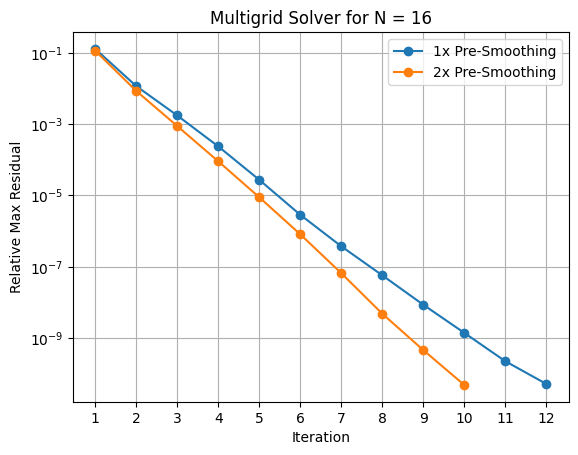

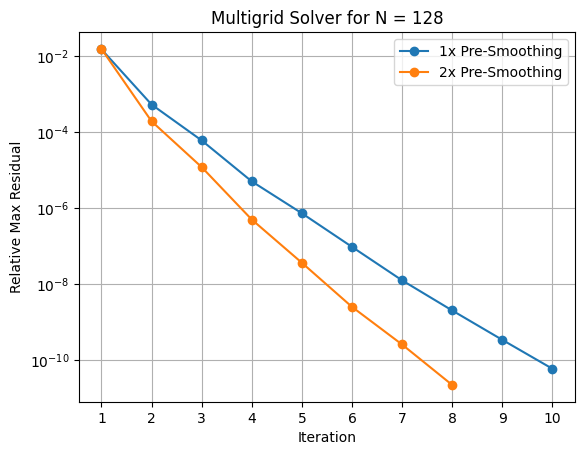

In [21]:
# Plotting residuals.

plt.plot(np.arange(1,len(rel_res_n4_nu1)+1,1), rel_res_n4_nu1, "-o")
plt.plot(np.arange(1,len(rel_res_n4_nu2)+1,1), rel_res_n4_nu2, "-o")
plt.xticks(np.arange(1, len(rel_res_n4_nu1)+1,1))
plt.yscale("log")
plt.grid()
plt.title("Multigrid Solver for N = 16")
plt.ylabel("Relative Max Residual")
plt.xlabel("Iteration")
plt.legend(["1x Pre-Smoothing", "2x Pre-Smoothing"])
#plt.savefig("Multigrid Solver n16.jpg")
plt.show()

plt.plot(np.arange(1,len(rel_res_n7_nu1)+1,1), rel_res_n7_nu1, "-o")
plt.plot(np.arange(1,len(rel_res_n7_nu2)+1,1), rel_res_n7_nu2, "-o")
plt.xticks(np.arange(1, len(rel_res_n7_nu1)+1,1))
plt.yscale("log")
plt.grid()
plt.title("Multigrid Solver for N = 128")
plt.ylabel("Relative Max Residual")
plt.xlabel("Iteration")
plt.legend(["1x Pre-Smoothing", "2x Pre-Smoothing"])
#plt.savefig("Multigrid Solver n128.jpg")
plt.show()